In [ ]:
"""
Team Nova:
Arpit Palo
Arun Kumar
Nisarg Gupta
Omkar Kanade
"""

# Code to merge temperature data with food data on basis of CountryCode, Month and Year

In [ ]:
!pip install reverse_geocoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for reverse_geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268067 sha256=c86de1fd66e3fb2ce5dc0868e8ebc3fc48763bd556b72d0e6b9f0f90a60b0aeb
  Stored in directory: /root/.cache/pip/wheels/bd/e5/88/eb139b6d6a26b8022d370ab991f7a836802fed9871975ec6d9
Successfully built reverse_geocoder


In [ ]:
import reverse_geocoder as rg 
import datetime
import time 
from urllib.request import urlopen
import os
import pandas as pd

In [ ]:
def reverseGeocode(coordinates): 
    '''coordinates - latitude, lognitude'''
    result = rg.search(coordinates)
    return [r['cc'] for r in result]

# Number of attempts to download data
MAX_ATTEMPTS = 6
# HTTPS here can be problematic for installs that don't have Lets Encrypt CA
SERVICE = "http://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?"

def download_data(uri):
    """Fetch the data from the IEM

    The IEM download service has some protections in place to keep the number
    of inbound requests in check.  This function implements an exponential
    backoff to keep individual downloads from erroring.

    Args:
      uri (string): URL to fetch

    Returns:
      string data
    """
    attempt = 0
    while attempt < MAX_ATTEMPTS:
        try:
            data = urlopen(uri, timeout=300).read().decode("utf-8")
            if data is not None and not data.startswith("ERROR"):
                return data
        except Exception as exp:
            print(f"download_data({uri}) failed with {exp}")
            time.sleep(5)
        attempt += 1

    print("Exhausted attempts to download, returning empty data")
    return ""

def fetch_data_for_year(year_start, year_end):
#     clear_working_dir()
    startts = datetime.datetime(year_start, 1, 1)
    endts = datetime.datetime(year_end+1, 1, 1)
    interval = datetime.timedelta(hours=24)

    service = SERVICE + "data=all&tz=Etc/UTC&format=onlycomma&latlon=yes&elev=no&missing=empty&trace=T&direct=no&report_type=3&report_type=4&"

    now = startts
    while now < endts:
        thisurl = service
        thisurl += now.strftime("year1=%Y&month1=%m&day1=%d&")
        thisurl += (now + interval).strftime("year2=%Y&month2=%m&day2=%d&")
        print(f"Downloading: {now}")
        data = download_data(thisurl)
        outfn = f"{now:%Y%m%d}.txt"
        with open(outfn, "w", encoding="ascii") as fh:
            fh.write(data)
        now += interval

In [ ]:
fdf = None
cols_to_keep = set(["valid", "lat","lon", "tmpf", "dwpf", "relh", "sknt", "p01i", "feel", "mslp", "ice_accretion_6hr"])

year = 2006

fetch_data_for_year(year, year)


Downloading: 2006-01-01 00:00:00
Downloading: 2006-01-02 00:00:00
Downloading: 2006-01-03 00:00:00
Downloading: 2006-01-04 00:00:00
Downloading: 2006-01-05 00:00:00
Downloading: 2006-01-06 00:00:00
Downloading: 2006-01-07 00:00:00
Downloading: 2006-01-08 00:00:00
Downloading: 2006-01-09 00:00:00
Downloading: 2006-01-10 00:00:00
Downloading: 2006-01-11 00:00:00
Downloading: 2006-01-12 00:00:00
Downloading: 2006-01-13 00:00:00
Downloading: 2006-01-14 00:00:00
Downloading: 2006-01-15 00:00:00
Downloading: 2006-01-16 00:00:00
Downloading: 2006-01-17 00:00:00
Downloading: 2006-01-18 00:00:00
Downloading: 2006-01-19 00:00:00
Downloading: 2006-01-20 00:00:00
Downloading: 2006-01-21 00:00:00
Downloading: 2006-01-22 00:00:00
Downloading: 2006-01-23 00:00:00
Downloading: 2006-01-24 00:00:00
Downloading: 2006-01-25 00:00:00
Downloading: 2006-01-26 00:00:00
Downloading: 2006-01-27 00:00:00
Downloading: 2006-01-28 00:00:00
Downloading: 2006-01-29 00:00:00
Downloading: 2006-01-30 00:00:00
Downloadin

In [ ]:
fdf = None
for dfile in os.listdir():
    if dfile.endswith(".txt"):
        try:
            df = pd.read_csv(dfile, engine = 'pyarrow', usecols = cols_to_keep)
            lat_lon = [(a, b) for a, b in df[['lat','lon']].values.tolist()]
            df["CountryCode"] = reverseGeocode(lat_lon)
            numeric_cols = ['tmpf', 'dwpf', 'mslp', 'sknt', 'feel', 'relh', 'ice_accretion_6hr', 'p01i']
            df[numeric_cols] = df[numeric_cols].replace({'M': None, 'T': None, '': None})
            df[numeric_cols] = df[numeric_cols].astype(float)
            df['Month'] = pd.to_datetime(df['valid']).dt.month
            df['Year'] = pd.to_datetime(df['valid']).dt.year
            df_grouped = df.groupby(['CountryCode', 'Month', 'Year']).agg({
                'tmpf': 'mean',
                'dwpf': 'mean',
                'mslp': 'mean',
                'sknt': 'mean',
                'feel': 'mean',
                'relh': 'mean',
                'ice_accretion_6hr': 'mean',
                'p01i': 'mean'
            }).reset_index()
            if fdf is None:
              fdf = df_grouped
            else:
              fdf = pd.concat([fdf, df_grouped], ignore_index=True)

        except Exception as e:
            print(e)
            pass

In [ ]:
df_final_group_by = fdf.groupby(['CountryCode', 'Month', 'Year']).agg({
                'tmpf': 'mean',
                'dwpf': 'mean',
                'mslp': 'mean',
                'sknt': 'mean',
                'feel': 'mean',
                'relh': 'mean',
                'ice_accretion_6hr': 'mean',
                'p01i': 'mean'
            }).reset_index()

In [ ]:
len(df_final_group_by)

2184

In [ ]:
df_final_group_by.to_csv("df_2006.csv", index = False)

In [ ]:
df_concatenated = pd.concat(all_df)
df_grouped = df_concatenated.groupby(['CountryCode', 'Month', 'Year']).agg({
                'tmpf': 'mean',
                'dwpf': 'mean',
                'mslp': 'mean',
                'sknt': 'mean',
                'feel': 'mean',
                'relh': 'mean',
                'ice_accretion_6hr': 'mean',
                'p01i': 'mean'
            }).reset_index()
df_grouped

In [ ]:
fileName = "df_"+str(year)+".csv"
df_grouped.to_csv(fileName)

In [ ]:
for f in os.listdir():
  if '.txt' in f:
    os.remove(f)

In [ ]:
import pandas as pd
food_security = pd.read_csv("Food_Security.csv")

In [ ]:
food_security.head()

,Unnamed: 0,Unnamed: 1,Total Grains/Cereals-Area Harvested-1000 Ha,Total Grains/Cereals-Yield-MT / Ha,Total Grains/Cereals-Production Quantity-1000 MT,"Economic Data-Gross Domestic Product, constant prices-Percent change",Economic Data-GDP (constant 2005 US$)-Million,Economic Data-Imports of goods and services (constant 2005 US$)-Million,Economic Data-Exports of goods and services (constant 2005 US$)-Million,Economic Data-WB GDP (constant 2005 US$) / FAO population-$/Person,...,Root Crops (R&T)-Food Availability per capita-kg/cap/yr,Total Grains/Cereals and Root Crops (R&T)-Production Quantity-Grain Equiv. 1000 MT,Total Grains/Cereals and Root Crops (R&T)-Food Availability per capita-kg/cap/yr,Total Grains/Cereals and Root Crops (R&T)-Food Supply-Grain Equiv. 1000 MT,Total Grains/Cereals and Root Crops (R&T)-Area Harvested-1000 Ha,Other-Food Supply-Grain Equiv. 1000 MT / yr,Other-Food Supply-Grain Equiv. kg/cap/yr,Food Aid-Cereal Food Aid-Grain Equiv. 1000 MT,Food Aid-Total-Grain Equiv. 1000 MT,Food Aid-Non-Cereal Food Aid-Grain Equiv. 1000 MT
0,1980,Algeria,3181.380,0.760260,2418.67440,-5.400,50817.865550,23782.380720,19637.946210,2701.497292,...,7.155336,2567.776695,206.507152,6024.013443,3257.390,1179.964073,347.613743,NaN,NaN,NaN
1,1980,Egypt,1978.165,3.693492,7306.33669,3.409,29082.086360,17147.303850,6230.543681,646.958675,...,5.287843,7638.101825,213.426124,13670.775190,2054.997,2475.294574,329.194628,NaN,NaN,NaN
2,1980,Morocco,4428.550,1.017297,4505.14958,3.792,25330.420140,5768.345685,3338.768767,1294.547971,...,5.033219,4644.477795,232.839781,6472.835445,4466.627,992.082476,358.771414,NaN,NaN,NaN
3,1980,Tunisia,1307.200,0.915545,1196.80000,7.400,11503.804050,6367.642589,4548.026542,1781.601991,...,4.019189,1226.175354,211.269924,2046.216214,1317.900,451.089620,362.529775,NaN,NaN,NaN
4,1980,Cameroon,1031.730,0.849638,876.59719,9.900,8699.570311,1406.764013,1683.875850,954.947345,...,44.780214,1412.611935,140.161663,1552.961235,1396.030,820.121012,257.184750,NaN,NaN,NaN


In [ ]:
food_security = food_security.rename(columns={'Unnamed: 0': 'Year', 'Unnamed: 1': 'Country'})

In [ ]:
food_security.head()

,Year,Country,Total Grains/Cereals-Area Harvested-1000 Ha,Total Grains/Cereals-Yield-MT / Ha,Total Grains/Cereals-Production Quantity-1000 MT,"Economic Data-Gross Domestic Product, constant prices-Percent change",Economic Data-GDP (constant 2005 US$)-Million,Economic Data-Imports of goods and services (constant 2005 US$)-Million,Economic Data-Exports of goods and services (constant 2005 US$)-Million,Economic Data-WB GDP (constant 2005 US$) / FAO population-$/Person,...,Root Crops (R&T)-Food Availability per capita-kg/cap/yr,Total Grains/Cereals and Root Crops (R&T)-Production Quantity-Grain Equiv. 1000 MT,Total Grains/Cereals and Root Crops (R&T)-Food Availability per capita-kg/cap/yr,Total Grains/Cereals and Root Crops (R&T)-Food Supply-Grain Equiv. 1000 MT,Total Grains/Cereals and Root Crops (R&T)-Area Harvested-1000 Ha,Other-Food Supply-Grain Equiv. 1000 MT / yr,Other-Food Supply-Grain Equiv. kg/cap/yr,Food Aid-Cereal Food Aid-Grain Equiv. 1000 MT,Food Aid-Total-Grain Equiv. 1000 MT,Food Aid-Non-Cereal Food Aid-Grain Equiv. 1000 MT
0,1980,Algeria,3181.380,0.760260,2418.67440,-5.400,50817.865550,23782.380720,19637.946210,2701.497292,...,7.155336,2567.776695,206.507152,6024.013443,3257.390,1179.964073,347.613743,NaN,NaN,NaN
1,1980,Egypt,1978.165,3.693492,7306.33669,3.409,29082.086360,17147.303850,6230.543681,646.958675,...,5.287843,7638.101825,213.426124,13670.775190,2054.997,2475.294574,329.194628,NaN,NaN,NaN
2,1980,Morocco,4428.550,1.017297,4505.14958,3.792,25330.420140,5768.345685,3338.768767,1294.547971,...,5.033219,4644.477795,232.839781,6472.835445,4466.627,992.082476,358.771414,NaN,NaN,NaN
3,1980,Tunisia,1307.200,0.915545,1196.80000,7.400,11503.804050,6367.642589,4548.026542,1781.601991,...,4.019189,1226.175354,211.269924,2046.216214,1317.900,451.089620,362.529775,NaN,NaN,NaN
4,1980,Cameroon,1031.730,0.849638,876.59719,9.900,8699.570311,1406.764013,1683.875850,954.947345,...,44.780214,1412.611935,140.161663,1552.961235,1396.030,820.121012,257.184750,NaN,NaN,NaN


In [ ]:
!pip install pycountry

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 67.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=50c2c9dfa99e9210652905a0cb191b2d56d33fddf6b82b39b4cd51d9e93f70a7
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built pycountry


In [ ]:
import pycountry
def get_country_code(country_name):
    try:
        country = pycountry.countries.search_fuzzy(country_name)[0]
        return country.alpha_2
    except LookupError:
        return None

# Apply the function to get country codes for each country name
food_security['Country Code'] = food_security['Country'].apply(get_country_code)

In [ ]:
food_security.head()

,Year,Country,Total Grains/Cereals-Area Harvested-1000 Ha,Total Grains/Cereals-Yield-MT / Ha,Total Grains/Cereals-Production Quantity-1000 MT,"Economic Data-Gross Domestic Product, constant prices-Percent change",Economic Data-GDP (constant 2005 US$)-Million,Economic Data-Imports of goods and services (constant 2005 US$)-Million,Economic Data-Exports of goods and services (constant 2005 US$)-Million,Economic Data-WB GDP (constant 2005 US$) / FAO population-$/Person,...,Total Grains/Cereals and Root Crops (R&T)-Production Quantity-Grain Equiv. 1000 MT,Total Grains/Cereals and Root Crops (R&T)-Food Availability per capita-kg/cap/yr,Total Grains/Cereals and Root Crops (R&T)-Food Supply-Grain Equiv. 1000 MT,Total Grains/Cereals and Root Crops (R&T)-Area Harvested-1000 Ha,Other-Food Supply-Grain Equiv. 1000 MT / yr,Other-Food Supply-Grain Equiv. kg/cap/yr,Food Aid-Cereal Food Aid-Grain Equiv. 1000 MT,Food Aid-Total-Grain Equiv. 1000 MT,Food Aid-Non-Cereal Food Aid-Grain Equiv. 1000 MT,Country Code
0,1980,Algeria,3181.380,0.760260,2418.67440,-5.400,50817.865550,23782.380720,19637.946210,2701.497292,...,2567.776695,206.507152,6024.013443,3257.390,1179.964073,347.613743,NaN,NaN,NaN,DZ
1,1980,Egypt,1978.165,3.693492,7306.33669,3.409,29082.086360,17147.303850,6230.543681,646.958675,...,7638.101825,213.426124,13670.775190,2054.997,2475.294574,329.194628,NaN,NaN,NaN,EG
2,1980,Morocco,4428.550,1.017297,4505.14958,3.792,25330.420140,5768.345685,3338.768767,1294.547971,...,4644.477795,232.839781,6472.835445,4466.627,992.082476,358.771414,NaN,NaN,NaN,MA
3,1980,Tunisia,1307.200,0.915545,1196.80000,7.400,11503.804050,6367.642589,4548.026542,1781.601991,...,1226.175354,211.269924,2046.216214,1317.900,451.089620,362.529775,NaN,NaN,NaN,TN
4,1980,Cameroon,1031.730,0.849638,876.59719,9.900,8699.570311,1406.764013,1683.875850,954.947345,...,1412.611935,140.161663,1552.961235,1396.030,820.121012,257.184750,NaN,NaN,NaN,CM


In [ ]:
food_security = food_security.rename(columns={'Country Code': 'CountryCode'})

In [ ]:
food_security.shape

(2584, 41)

In [ ]:
cols_to_keep = ['CountryCode', 'Month', 'Year','tmpf', 'dwpf', 'mslp', 'sknt', 'feel', 'relh', 'ice_accretion_6hr', 'p01i']
merged_df = pd.read_csv("Merged_Temp_New.csv", usecols = cols_to_keep )

In [ ]:
merged_df.head()

,CountryCode,Month,Year,tmpf,dwpf,mslp,sknt,feel,relh,ice_accretion_6hr,p01i
0,AE,1,1998,65.458763,56.045068,1018.097921,6.545845,65.486669,73.471497,NaN,NaN
1,AE,2,1998,68.562623,54.735838,1016.853637,7.247619,68.508641,64.828713,NaN,NaN
2,AE,3,1998,75.013693,57.406706,1014.256000,7.266628,74.756180,59.583567,NaN,NaN
3,AE,4,1998,82.306805,58.289718,1010.446900,7.312550,82.352514,49.981098,NaN,NaN
4,AE,5,1998,90.308306,60.247751,1006.463388,6.752338,91.290631,42.404219,NaN,NaN


In [ ]:
df_grouped = merged_df.groupby(['CountryCode', 'Year']).agg({
                'tmpf': 'mean',
                'dwpf': 'mean',
                'mslp': 'mean',
                'sknt': 'mean',
                'feel': 'mean',
                'relh': 'mean',
                'ice_accretion_6hr': 'mean',
                'p01i': 'mean'
            }).reset_index()

In [ ]:
merged_df = pd.merge(df_grouped, food_security, on=['Year', 'CountryCode'], how='inner')

In [ ]:
merged_df

,CountryCode,Year,tmpf,dwpf,mslp,sknt,feel,relh,ice_accretion_6hr,p01i,...,Root Crops (R&T)-Food Availability per capita-kg/cap/yr,Total Grains/Cereals and Root Crops (R&T)-Production Quantity-Grain Equiv. 1000 MT,Total Grains/Cereals and Root Crops (R&T)-Food Availability per capita-kg/cap/yr,Total Grains/Cereals and Root Crops (R&T)-Food Supply-Grain Equiv. 1000 MT,Total Grains/Cereals and Root Crops (R&T)-Area Harvested-1000 Ha,Other-Food Supply-Grain Equiv. 1000 MT / yr,Other-Food Supply-Grain Equiv. kg/cap/yr,Food Aid-Cereal Food Aid-Grain Equiv. 1000 MT,Food Aid-Total-Grain Equiv. 1000 MT,Food Aid-Non-Cereal Food Aid-Grain Equiv. 1000 MT
0,AF,1980,63.507106,40.293937,1012.071430,4.025317,62.544066,49.311788,NaN,NaN,...,NaN,3933.805000,NaN,3950.905000,3036.400,NaN,NaN,NaN,NaN,NaN
1,AF,1981,64.205946,41.658434,1012.353722,3.823075,63.820333,49.646717,NaN,NaN,...,NaN,3763.130000,NaN,3859.630000,2926.700,NaN,NaN,NaN,NaN,NaN
2,AF,1982,62.434431,40.484110,1013.034734,2.743667,61.751409,51.655215,NaN,NaN,...,NaN,3602.788000,NaN,3677.688000,2817.100,NaN,NaN,NaN,NaN,NaN
3,AF,1983,63.557293,41.876919,1012.432635,3.554338,63.099168,51.061917,NaN,NaN,...,NaN,3474.450000,NaN,3553.953000,2666.000,NaN,NaN,NaN,NaN,NaN
4,AF,1984,63.021090,40.408504,1012.665623,3.779191,62.323171,49.637630,NaN,NaN,...,NaN,3306.778000,NaN,3327.928000,2580.000,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817,ZW,2009,69.178092,51.142729,987.033333,5.766506,68.992368,58.371197,NaN,NaN,...,7.190499,1677.731196,141.317483,2256.195171,2146.740,659.317759,252.422208,217.997711,287.112748,69.115038
1818,ZW,2010,70.479057,54.122931,996.616667,5.562661,70.427815,61.400107,NaN,0.0,...,7.113236,1723.572567,136.990970,2094.336542,1951.794,664.444728,248.095696,63.648974,98.299925,34.650952
1819,ZW,2011,69.492740,51.344388,951.916667,5.717720,69.263550,58.139460,NaN,0.0,...,7.448523,1765.470308,139.933312,2407.634283,1994.544,674.117259,251.038038,32.984747,57.430583,24.445836
1820,ZW,2012,70.705551,50.856807,NaN,5.597443,70.348453,55.440169,NaN,0.0,...,7.427756,1255.897663,142.318797,1878.061638,1493.966,687.859653,253.423522,26.456731,42.538873,16.082141


In [ ]:
merged_df.to_csv("Temp_Food_Yearly.csv")

In [ ]:
cols = ['CountryCode', 'Month', 'Year', 'tmpf', 'dwpf', 'mslp',
       'sknt', 'feel', 'relh', 'ice_accretion_6hr', 'p01i', 'Methane Levels',
       'CO2 Levels', 'NO Levels']
temp_ghg_df = pd.read_csv("merged_temp_ghg.csv", usecols = cols)

In [ ]:
temp_ghg_df.columns

Index(['CountryCode', 'Month', 'Year', 'tmpf', 'dwpf', 'mslp', 'sknt', 'feel',
       'relh', 'ice_accretion_6hr', 'p01i', 'Methane Levels', 'CO2 Levels',
       'NO Levels'],
      dtype='object')

In [ ]:
temp_ghg_df.head()

,CountryCode,Month,Year,tmpf,dwpf,mslp,sknt,feel,relh,ice_accretion_6hr,p01i,Methane Levels,CO2 Levels,NO Levels
0,AE,1,1998,65.458763,56.045068,1018.097921,6.545845,65.486669,73.471497,NaN,NaN,1806.199585,366.751877,313.954544
1,AE,2,1998,68.562623,54.735838,1016.853637,7.247619,68.508641,64.828713,NaN,NaN,1805.311157,367.808334,313.976395
2,AE,3,1998,75.013693,57.406706,1014.256000,7.266628,74.756180,59.583567,NaN,NaN,1803.840637,368.712509,314.042526
3,AE,4,1998,82.306805,58.289718,1010.446900,7.312550,82.352514,49.981098,NaN,NaN,1799.752197,369.476974,314.056015
4,AE,5,1998,90.308306,60.247751,1006.463388,6.752338,91.290631,42.404219,NaN,NaN,1792.533752,369.468079,314.104630


In [ ]:
temp_ghg_df.dropna(subset=['tmpf'], inplace=True)

In [ ]:
temp_ghg_df['tmpf'].isna().sum()

0

In [ ]:
import matplotlib.pyplot as plt
temp_ghg_df['Date'] = pd.to_datetime(temp_ghg_df[['Year', 'Month']].assign(day=1))
# Step 2: Subset the data for a specific country
country = 'US'  # Replace 'Your Country' with the name of your desired country
country_data = temp_ghg_df[temp_ghg_df['CountryCode'] == country]
country_data.index = country_data['Date']
# Step 3: Perform time series analysis
# Example: Plot the temperature over time
# plt.figure(figsize=(10, 6))
# plt.plot(country_data['tmpf'])
# plt.title(f'Temperature Time Series for {country}')
# plt.xlabel('Date')
# plt.ylabel('Temperature')
# plt.show()

In [ ]:
country_data.head()
rolling_mean = country_data['tmpf'].rolling(4).mean()
rolling_std = country_data['tmpf'].rolling(4).std()

In [ ]:
from statsmodels.tsa.stattools import adfuller
adft = adfuller(country_data['tmpf'],autolag="AIC")

In [ ]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

       Values                       Metric
0   -5.617484              Test Statistics
1    0.000001                      p-value
2   20.000000             No. of lags used
3  640.000000  Number of observations used
4   -3.440609          critical value (1%)
5   -2.866067          critical value (5%)
6   -2.569181         critical value (10%)


In [ ]:
autocorrelation_lag1 = country_data['tmpf'].autocorr(lag=1)
print(autocorrelation_lag1)

0.8551842886347414


In [ ]:
autocorrelation_lag2 = country_data['tmpf'].autocorr(lag=2)
print("TwO Month Lag: ", autocorrelation_lag2)

autocorrelation_lag3 = country_data['tmpf'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = country_data['tmpf'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = country_data['tmpf'].autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

TWO Month Lag:  0.4919100102856963
Three Month Lag:  0.0017660704338355378
Six Month Lag:  -0.9681341734888166
Nine Month Lag:  -0.004481996483804083


In [ ]:
country_data

,CountryCode,Month,Year,tmpf,dwpf,mslp,sknt,feel,relh,ice_accretion_6hr,p01i,Methane Levels,CO2 Levels,NO Levels,Date
613,US,1,1960,34.214759,26.338590,1018.518491,7.381246,28.641326,74.892992,NaN,0.033119,1326.808079,319.027551,292.730741,1960-01-01
614,US,2,1960,35.732026,26.231879,1015.953854,8.701161,29.784135,71.189995,NaN,0.038100,1326.804827,319.761491,292.736050,1960-02-01
615,US,3,1960,38.293719,26.847885,1018.422128,8.316567,32.838286,67.412301,NaN,0.033794,1325.974014,320.435049,292.776521,1960-03-01
616,US,4,1960,54.016898,39.110391,1014.564218,8.729780,51.604052,62.430280,NaN,0.044100,1322.320354,320.959142,292.780985,1960-04-01
617,US,5,1960,61.510020,46.599481,1012.783897,7.914800,60.583720,63.756541,NaN,0.051242,1316.764513,320.617924,292.785889,1960-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,US,8,2014,72.252560,61.498121,1014.461289,4.745645,73.412104,73.069237,0.065000,0.003634,1879.399899,392.774305,327.214862,2014-08-01
20,US,9,2014,66.037181,56.111632,1015.591374,5.243123,66.413102,74.299550,0.016667,0.003280,1892.754044,394.299605,327.354648,2014-09-01
21,US,10,2014,56.668625,45.610896,1013.903489,5.935656,55.585235,70.888503,0.019268,0.002763,1900.957056,398.304282,327.557932,2014-10-01
22,US,11,2014,40.427157,29.939209,1017.851099,7.220360,36.047495,69.955390,0.031089,0.002425,1906.120414,401.657214,327.788978,2014-11-01


In [ ]:
food_temp = pd.read_csv("Food_Security.csv")

In [ ]:
merged_df.head(30)

,CountryCode,Year,tmpf,dwpf,mslp,sknt,feel,relh,ice_accretion_6hr,p01i,...,Root Crops (R&T)-Food Availability per capita-kg/cap/yr,Total Grains/Cereals and Root Crops (R&T)-Production Quantity-Grain Equiv. 1000 MT,Total Grains/Cereals and Root Crops (R&T)-Food Availability per capita-kg/cap/yr,Total Grains/Cereals and Root Crops (R&T)-Food Supply-Grain Equiv. 1000 MT,Total Grains/Cereals and Root Crops (R&T)-Area Harvested-1000 Ha,Other-Food Supply-Grain Equiv. 1000 MT / yr,Other-Food Supply-Grain Equiv. kg/cap/yr,Food Aid-Cereal Food Aid-Grain Equiv. 1000 MT,Food Aid-Total-Grain Equiv. 1000 MT,Food Aid-Non-Cereal Food Aid-Grain Equiv. 1000 MT
0,AF,1980,63.507106,40.293937,1012.071430,4.025317,62.544066,49.311788,NaN,NaN,...,NaN,3933.805,NaN,3950.905,3036.400,NaN,NaN,NaN,NaN,NaN
1,AF,1981,64.205946,41.658434,1012.353722,3.823075,63.820333,49.646717,NaN,NaN,...,NaN,3763.130,NaN,3859.630,2926.700,NaN,NaN,NaN,NaN,NaN
2,AF,1982,62.434431,40.484110,1013.034734,2.743667,61.751409,51.655215,NaN,NaN,...,NaN,3602.788,NaN,3677.688,2817.100,NaN,NaN,NaN,NaN,NaN
3,AF,1983,63.557293,41.876919,1012.432635,3.554338,63.099168,51.061917,NaN,NaN,...,NaN,3474.450,NaN,3553.953,2666.000,NaN,NaN,NaN,NaN,NaN
4,AF,1984,63.021090,40.408504,1012.665623,3.779191,62.323171,49.637630,NaN,NaN,...,NaN,3306.778,NaN,3327.928,2580.000,NaN,NaN,NaN,NaN,NaN
5,AF,1985,64.273848,40.317454,1011.717618,4.231464,63.521402,47.719768,NaN,NaN,...,NaN,3136.439,NaN,3194.863,2452.100,NaN,NaN,NaN,NaN,NaN
6,AF,1986,53.546064,39.006735,1019.647374,5.946667,51.093277,64.665231,NaN,NaN,...,NaN,2972.112,NaN,3081.285,2362.000,NaN,NaN,NaN,NaN,NaN
7,AF,1987,64.983466,40.257560,1012.867821,4.355542,64.426471,45.651114,NaN,NaN,...,NaN,3286.108,NaN,3557.873,2510.000,NaN,NaN,NaN,NaN,NaN
8,AF,1988,66.199525,41.916022,1011.106846,4.767968,65.810581,46.776017,NaN,NaN,...,NaN,2882.781,NaN,3115.565,2345.000,NaN,NaN,0.000000,0.000000,0.000000
9,AF,1989,66.239431,43.618669,1012.496577,5.508342,65.399110,51.432981,NaN,NaN,...,NaN,2727.440,NaN,3009.261,2303.300,NaN,NaN,362.887139,378.260236,15.373097


In [ ]:
all_countries = merged_df['CountryCode'].unique()

In [ ]:
print(all_countries)

['AF' 'AM' 'AO' 'AZ' 'BD' 'BF' 'BI' 'BJ' 'BO' 'CG' 'CI' 'CM' 'CO' 'DZ'
 'EC' 'EG' 'ER' 'ET' 'GE' 'GH' 'GM' 'GN' 'GT' 'GW' 'HN' 'HT' 'ID' 'IN'
 'JM' 'KE' 'KG' 'KH' 'KP' 'LK' 'LR' 'LS' 'MA' 'MD' 'MG' 'ML' 'MN' 'MR'
 'MW' 'MZ' 'NG' 'NI' 'NP' 'PE' 'PH' 'PK' 'RW' 'SD' 'SL' 'SN' 'SO' 'SV'
 'TD' 'TG' 'TJ' 'TM' 'TN' 'TZ' 'UG' 'UZ' 'VN' 'YE' 'ZM' 'ZW']


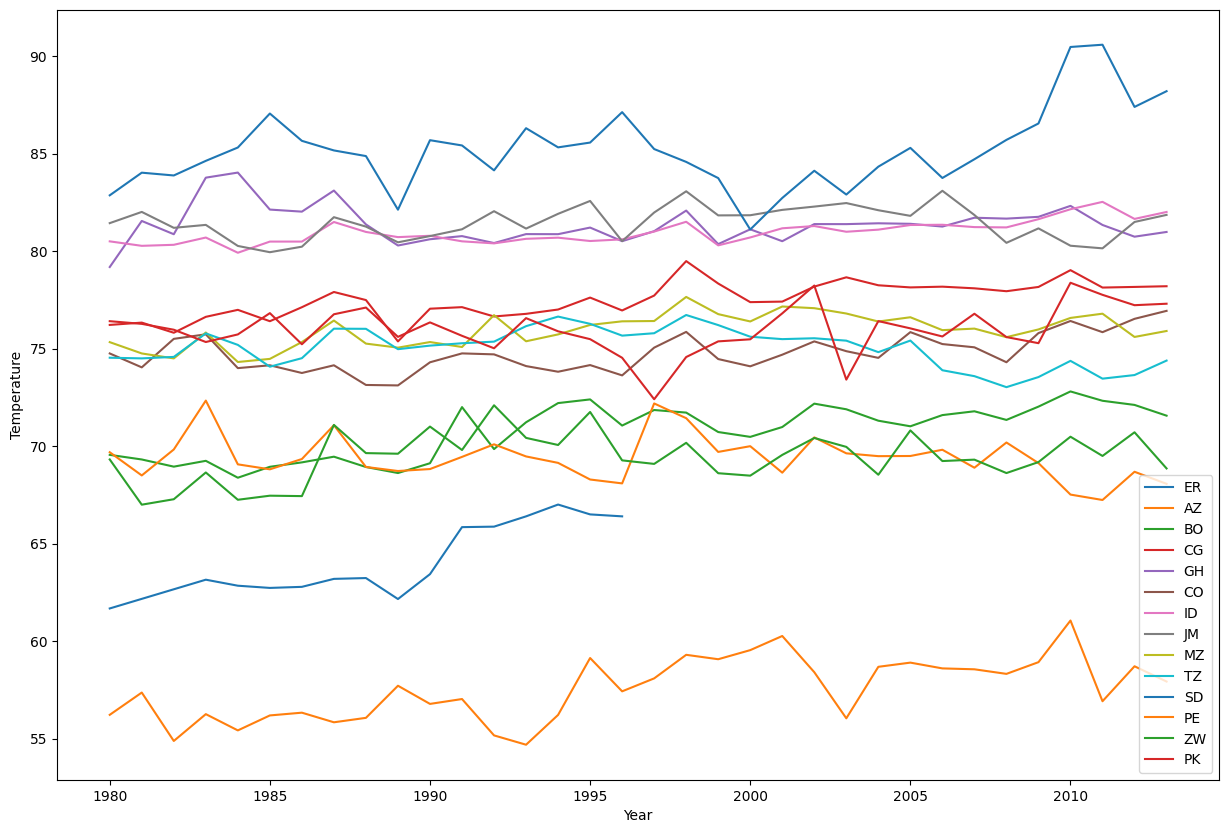

In [ ]:
plt.figure(figsize=(15, 10))
for country in countries_to_show:
  country_data = merged_df[ merged_df['CountryCode'] == country ]
  country_temp_data = country_data['tmpf']
  country_years_data = country_data['Year'] 
  plt.plot(country_years_data, country_temp_data, label = country)
  plt.xlabel('Year')
  plt.ylabel('Temperature')

plt.legend()
plt.show()

In [ ]:
countries_to_show = ['ER', 'AZ', 'BO', 'CG', 'GH','CO', 'ID','JM', 'MZ', 'TZ', 'SD', 'PE', 'ZW', 'PK']